In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

from tqdm import tqdm

plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")
image_path = 'C:/Users/rears/OneDrive/바탕 화면/dacon_covid19/'

raw_file_folders = os.listdir(raw_file_path)

folder_path = os.path.join(raw_file_path, raw_file_folders[4])

c:\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
file_name=os.listdir(folder_path)[1]

In [3]:
file_path = os.path.join(folder_path, file_name)
cj_deliv = pd.read_excel(file_path)

In [4]:
from bs4 import BeautifulSoup
import requests

years = [2019,2020]
months  = ["01","02","03","04","05"]

holiday_list = []
for year in years:
    for month in tqdm(months):
        api_key = 'J5rBwA3iTfCmVk2bbIYJM7JalT9IhO%2FAYU0wz2xK3Je3NQRfcmf38Mj4hWl6j8KgR4C9IgOKo35cHkwLaw053A%3D%3D'
        url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo?solYear={}&solMonth={}&ServiceKey={}'.format(year,month,api_key)
        get_data = requests.get(url)
        soup = BeautifulSoup(get_data.content, 'html.parser')
        table = soup.find_all('locdate')
        holiday_list = holiday_list + [day.text for day in table]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.77it/s]


In [4]:
holiday = pd.to_datetime(['2019-02-04','2019-02-05','2019-02-06','2019-03-01','2019-05-06','2019-05-12','2020-04-15', '2020-04-30','2020-05-05'])

In [5]:
folder_path = os.path.join(raw_file_path, raw_file_folders[0])
card_files = [file for file in os.listdir(csv_file_path) if file.startswith('카드')]

df_list = []

for file_name in card_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list.append(df)
    
foreigner = df_list[1]
register = df_list[0]

register = register.drop(register.columns[0], axis=1)
foreigner = foreigner.drop(foreigner.columns[0], axis=1)

cat_dict = {10 : '숙박',
20 : '레저용품',
21 : '레저업소',
22 : '문화취미',
30 : '가구',
31 : '전기',
32 : '주방용구',
33 : '연료판매',
34 : '광학제품',
35 : '가전',
40 : '유통업',
42 : '의복',
43 : '직물',
44 : '신변잡화',
50 : '서적문구',
52 : '사무통신',
60 : '자동차판매',
62 : '자동차 정비',
70 : '의료기관',
71 : '보건위생',
80 : '요식업소',
81 : '음료식품',
92 : '수리서비스'}

with open(os.path.join(pickle_file_path,'card_code_to_name_dict.pickle'), 'rb') as f:
    card_code_to_dong_dict = pickle.load(f)

register['region_code'] = register.GU_CD.astype(str)+register.DONG_CD.astype(str)
register['HDONG_NM'] = register.region_code.map(card_code_to_dong_dict.get('행정동명'))
register['MCT_CAT_NM'] = register.MCT_CAT_CD.map(cat_dict)

register['STD_DD'] = pd.to_datetime(register['STD_DD'], format='%Y%m%d')

register['year'] = register['STD_DD'].dt.year.values
register['month'] = register['STD_DD'].dt.month.values
register['weekofyear'] = register['STD_DD'].dt.weekofyear.values
register['dayofweek'] = register['STD_DD'].dt.dayofweek.values

register['weekday'] = np.where(register.dayofweek<5,'평일','주말')

c:\python37\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [6]:
covid_df = pd.read_csv(os.path.join(csv_file_path,'covid19_일별확진자.csv'))
covid_df['날짜'] = pd.to_datetime(covid_df.날짜)

covid_df = covid_df.iloc[8:129]

In [7]:
cj_deliv['DL_YMD'] = pd.to_datetime(cj_deliv.DL_YMD.apply(lambda x : '20'+str(x)), format='%Y%m%d')

In [8]:
cj_deliv['year'] = cj_deliv.DL_YMD.dt.year.values
cj_deliv['month'] = cj_deliv.DL_YMD.dt.month.values
cj_deliv['weekofyear'] = cj_deliv.DL_YMD.dt.weekofyear.values
cj_deliv['dayofweek'] = cj_deliv.DL_YMD.dt.dayofweek.values

cj_deliv['weekday'] = np.where(cj_deliv.dayofweek < 5, '평일', '주말')

c:\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# 휴일의 경우 주말과 같이 처리
cj_deliv.loc[cj_deliv.DL_YMD.isin(holiday),'weekday'] = '주말'

In [17]:
cj_cat_unstack = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM','DL_GD_LCLS_NM'])['INVC_CONT'].sum().\
        reset_index().\
        pivot_table(values='INVC_CONT', index=['DL_YMD','CTPV_NM','CTGG_NM'], columns=['DL_GD_LCLS_NM'], aggfunc='sum').\
        reset_index().\
        sort_values(by=['CTPV_NM','CTGG_NM','DL_YMD']).\
        reset_index(drop=True).\
        fillna(0)

In [18]:
tmp_df = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM'])['INVC_CONT'].sum().reset_index()
# tmp_df = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM','DL_GD_LCLS_NM'])['INVC_CONT'].sum().reset_index()

대구광역시 수성구


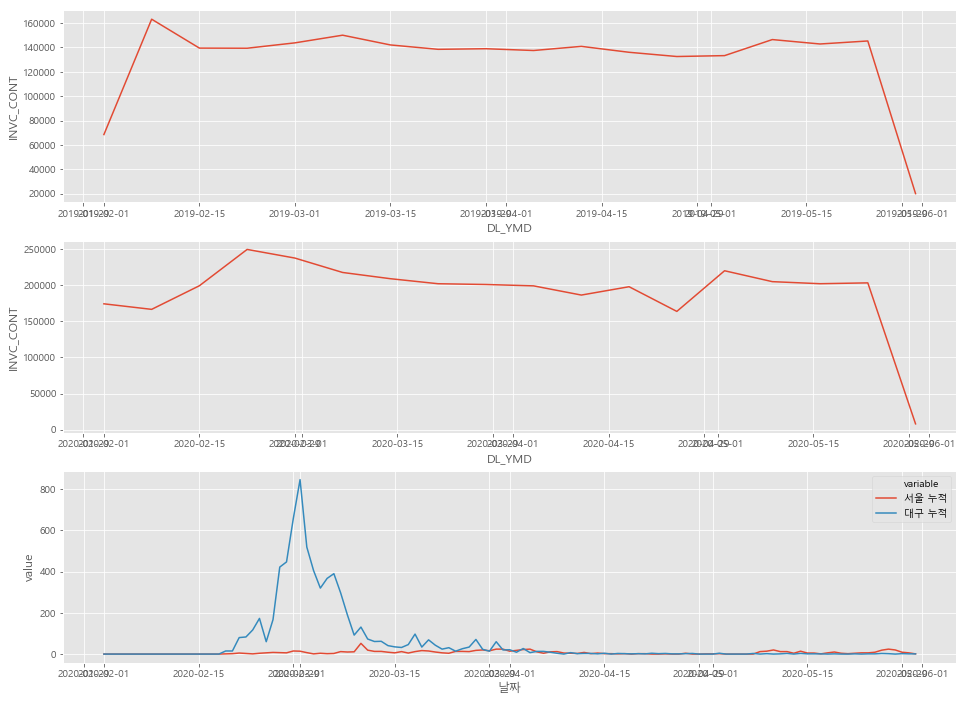

대구광역시 중구


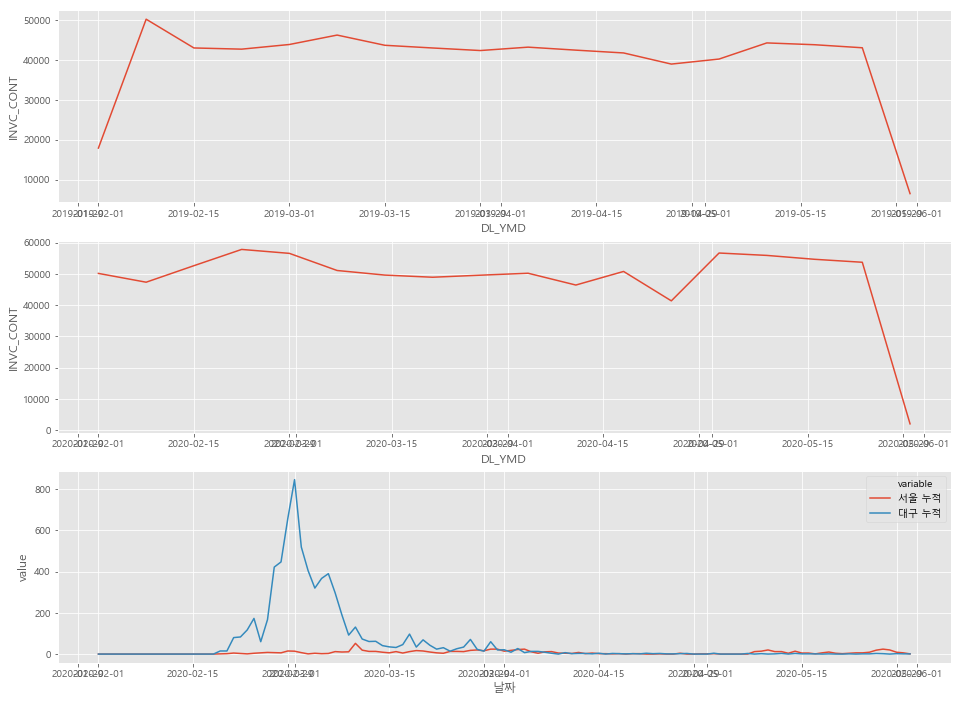

서울특별시 노원구


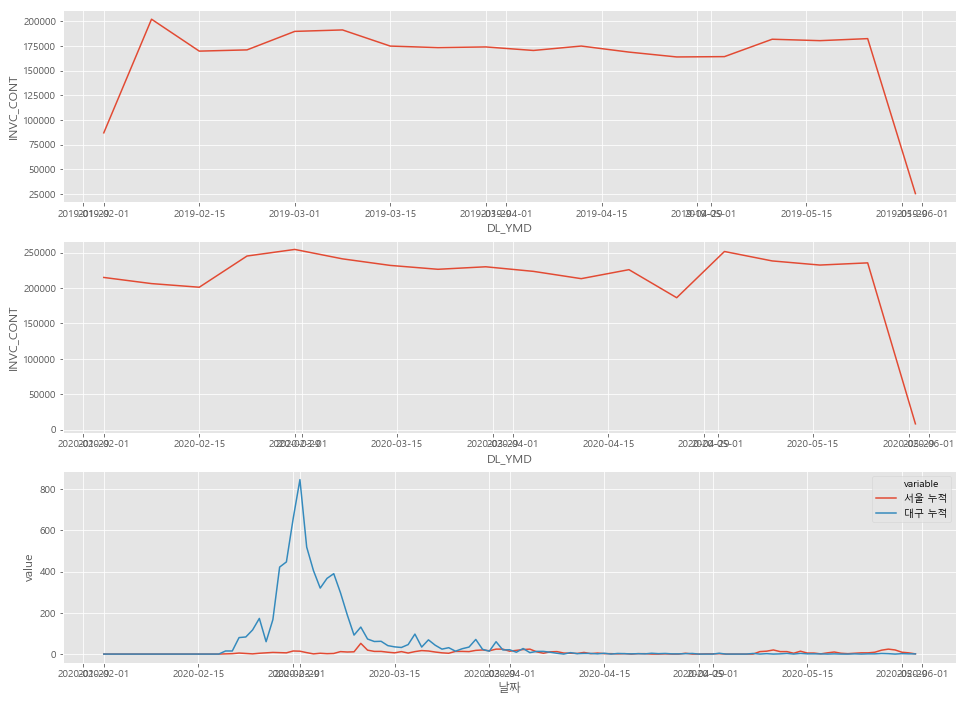

서울특별시 중구


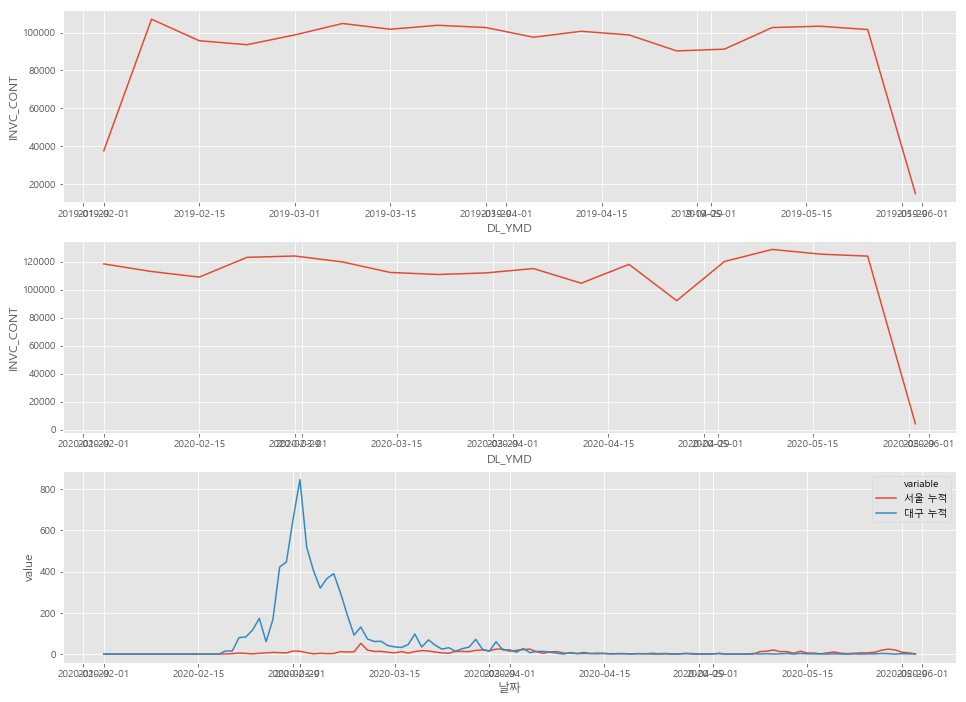

In [162]:
for si,gu in tmp_df.drop_duplicates(['CTPV_NM','CTGG_NM'])[['CTPV_NM','CTGG_NM']].values:
    print(f'{si} {gu}')
    tmp = tmp_df.loc[(tmp_df.CTPV_NM == si) & (tmp_df.CTGG_NM==gu) & (tmp_df.DL_YMD.dt.year==2020)]
    tmp1 = tmp_df.loc[(tmp_df.CTPV_NM == si) & (tmp_df.CTGG_NM==gu) & (tmp_df.DL_YMD.dt.year==2019)]
    
    plt.figure(figsize=(16,12))
    plt.subplot(311)
    sns.lineplot(
        data = tmp1.set_index('DL_YMD').resample('7D').sum().reset_index(),
        x = 'DL_YMD',
        y = 'INVC_CONT',
        #hue = 'DL_GD_LCLS_NM'
    )
    
    plt.subplot(312)
    sns.lineplot(
        data = tmp.set_index('DL_YMD').resample('7D').sum().reset_index(),
        x = 'DL_YMD',
        y = 'INVC_CONT',
        #hue = 'DL_GD_LCLS_NM'
    )
    
    plt.subplot(313)
    sns.lineplot(
        data = covid_df.iloc[:,[0,1,3]].melt(id_vars='날짜'),
        x = '날짜',
        y = 'value',
        hue = 'variable'
    )
    
    plt.show()

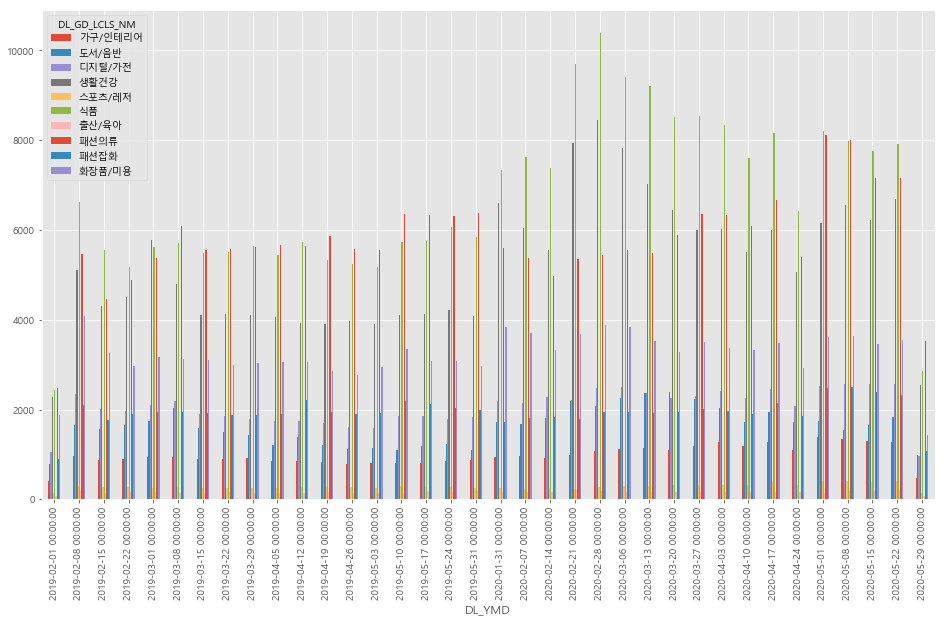

In [70]:
cj_cat_unstack.loc[cj_cat_unstack.CTGG_NM=='노원구'].set_index('DL_YMD').resample('7D').mean().dropna().plot(kind ='bar',figsize=(16,9))

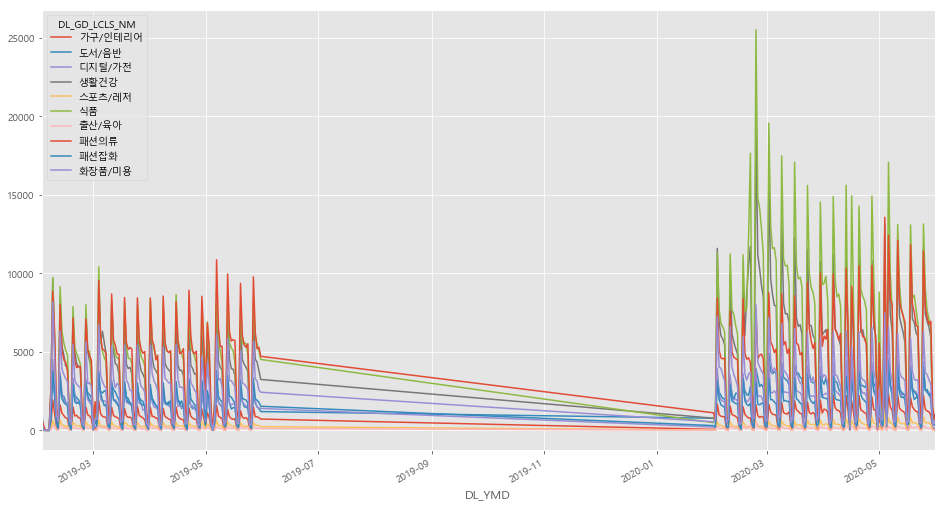

In [54]:
cj_cat_unstack.loc[cj_cat_unstack.CTGG_NM=='수성구'].set_index('DL_YMD').drop(['CTPV_NM','CTGG_NM'], axis=1).plot(figsize=(16,9))

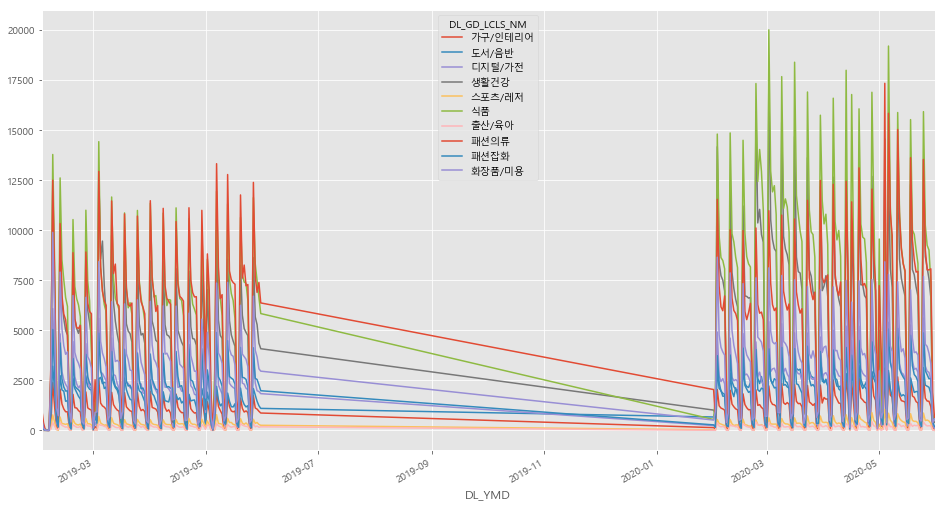

In [55]:
cj_cat_unstack.loc[cj_cat_unstack.CTGG_NM=='노원구'].set_index('DL_YMD').drop(['CTPV_NM','CTGG_NM'], axis=1).plot(figsize=(16,9))

In [32]:
cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM=='식품')].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna()

DL_YMD
2019-02-07     8025.6
2019-02-08    11795.6
2019-02-11    17905.8
2019-02-12    22194.6
2019-02-13    24714.8
               ...   
2020-05-25    27680.8
2020-05-26    27815.8
2020-05-27    27178.0
2020-05-28    26894.2
2020-05-29    26446.0
Name: INVC_CONT, Length: 167, dtype: float64

In [36]:
cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna().index

DatetimeIndex(['2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21',
               ...
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-25', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29'],
              dtype='datetime64[ns]', name='DL_YMD', length=166, freq=None)

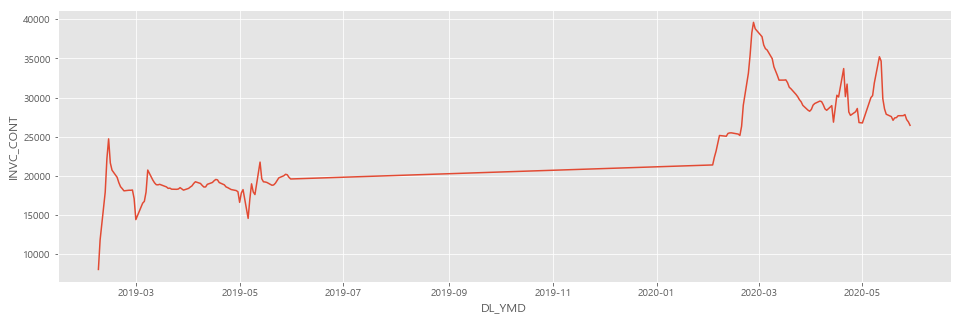

In [10]:
plt.figure(figsize=(16,5))
sns.lineplot(
    x=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM=='식품')].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna().index,
    y=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM=='식품')].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna()
)

In [14]:
cj_deliv.query('year==2020 & month==5')

,DL_YMD,DL_GD_LCLS_NM,DL_GD_LCLS_CD,CTPV_NM,CTPV_CD,CTGG_NM,CTGG_CD,HDNG_NM,HDNG_CD,INVC_CONT,year,month,weekofyear,dayofweek,weekday
136095,2020-05-01,도서/음반,12,서울특별시,11,노원구,35,상계3.4동,665,26,2020,5,18,4,평일
136096,2020-05-01,도서/음반,12,대구광역시,27,중구,11,대봉1동,680,29,2020,5,18,4,평일
136097,2020-05-01,가구/인테리어,10,서울특별시,11,노원구,35,월계3동,580,71,2020,5,18,4,평일
136098,2020-05-01,가구/인테리어,10,서울특별시,11,노원구,35,중계1동,621,66,2020,5,18,4,평일
136099,2020-05-01,디지털/가전,13,대구광역시,27,수성구,26,수성4가동,590,68,2020,5,18,4,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156566,2020-05-31,패션의류,19,대구광역시,27,수성구,26,범물2동,662,22,2020,5,22,6,주말
156567,2020-05-31,패션의류,19,서울특별시,11,중구,14,약수동,635,21,2020,5,22,6,주말
156568,2020-05-31,패션잡화,20,대구광역시,27,수성구,26,범물2동,662,14,2020,5,22,6,주말
156569,2020-05-31,패션잡화,20,서울특별시,11,노원구,35,상계6.7동,695,25,2020,5,22,6,주말


In [23]:
cj_deliv.loc[cj_deliv.DL_YMD.isin(['2019-04-29','2019-04-30','2019-05-01'])].groupby(['DL_YMD'])['INVC_CONT'].sum()

DL_YMD
2019-04-29    120462
2019-04-30     80270
2019-05-01     34383
Name: INVC_CONT, dtype: int64

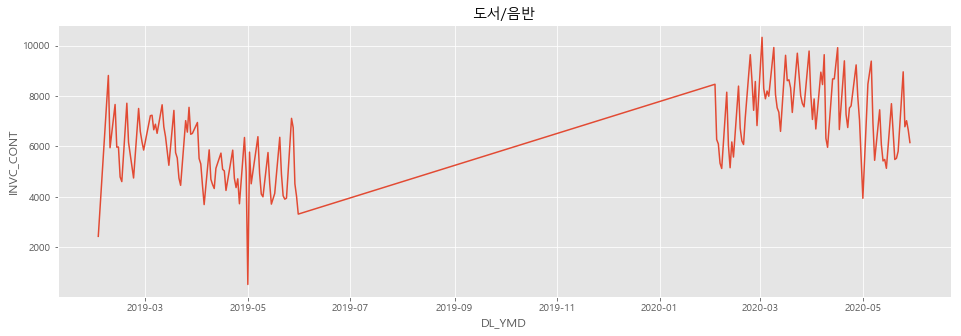

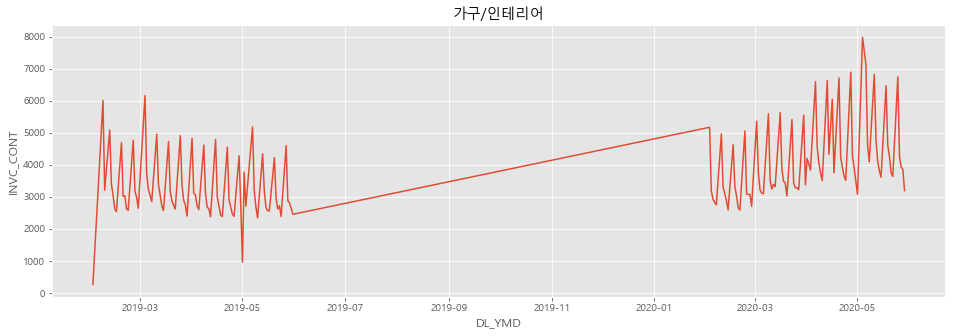

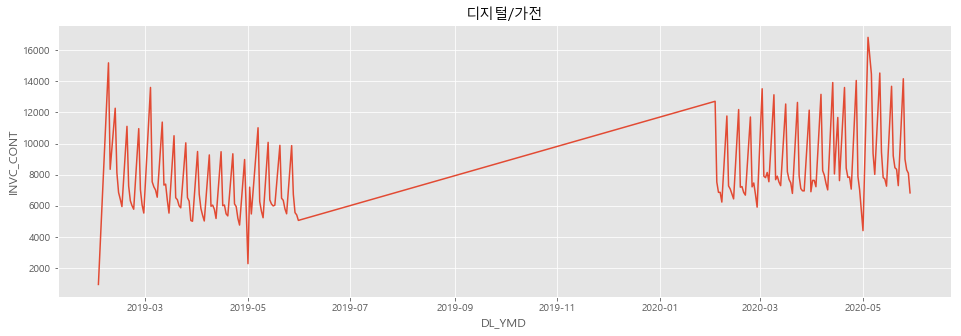

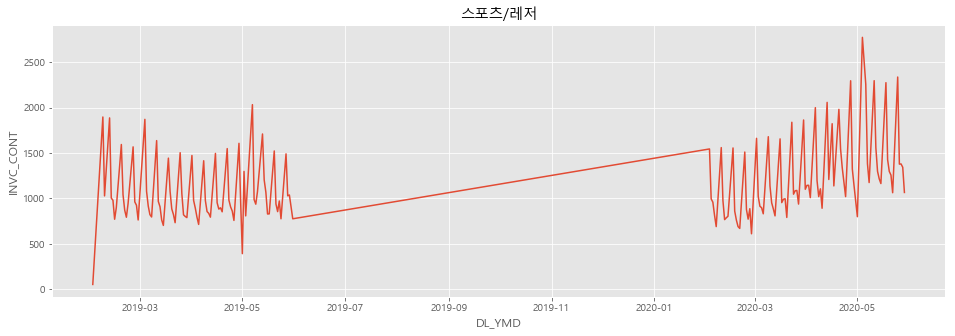

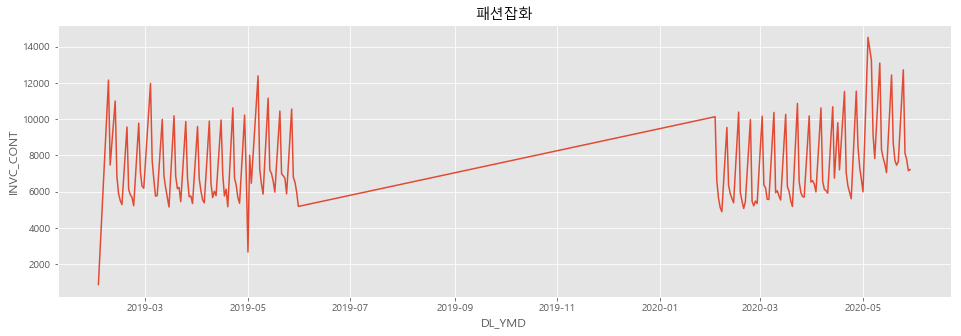

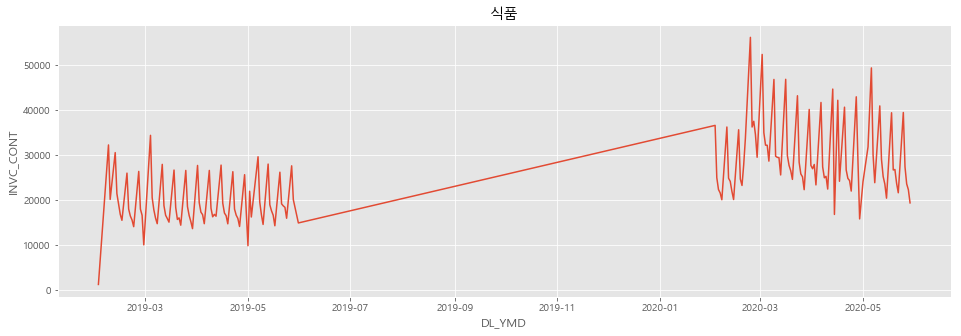

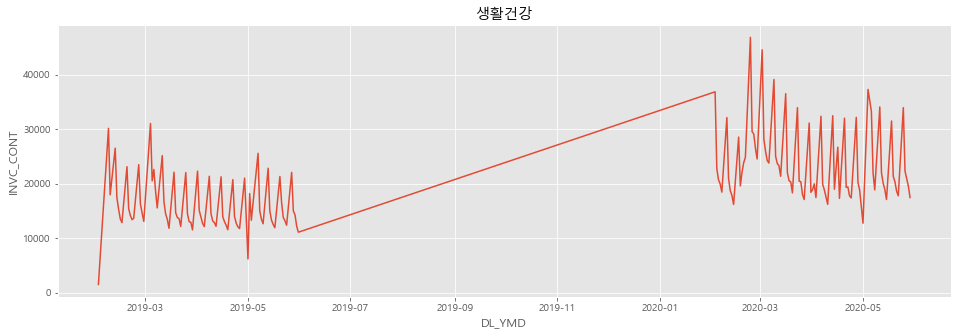

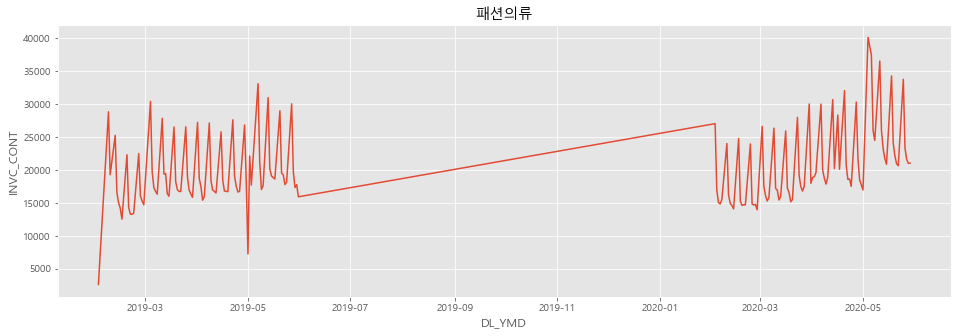

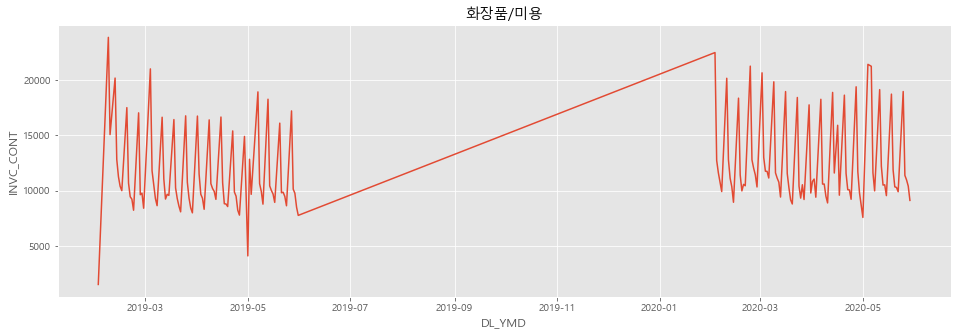

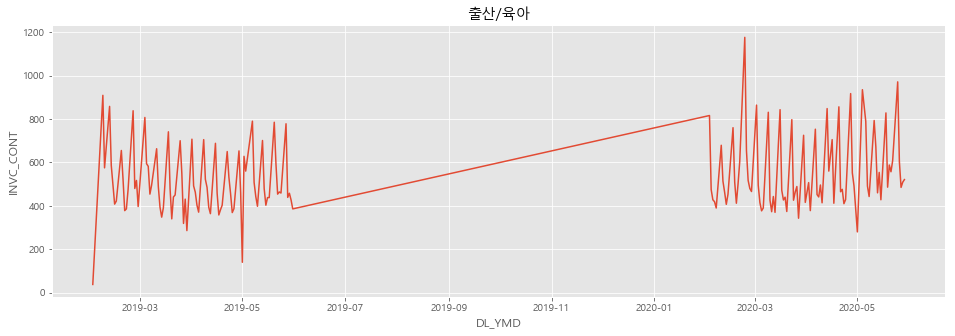

In [21]:
for cat in cj_deliv.DL_GD_LCLS_NM.unique():
    
    plt.figure(figsize=(16,5))
    sns.lineplot(
        x=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().index,
        y=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum()
    )
    plt.title(cat)
    plt.show()

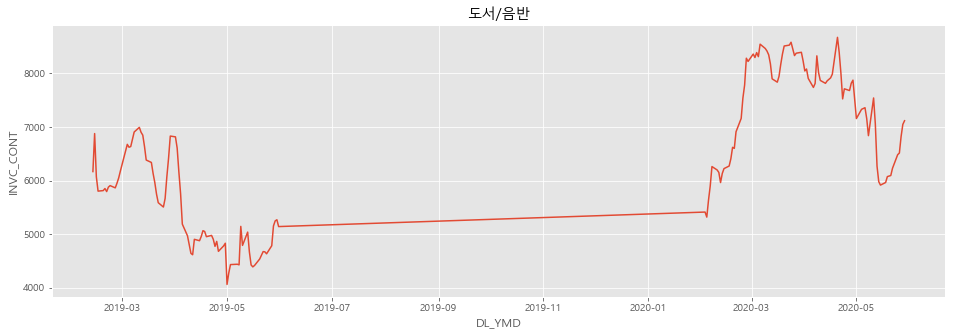

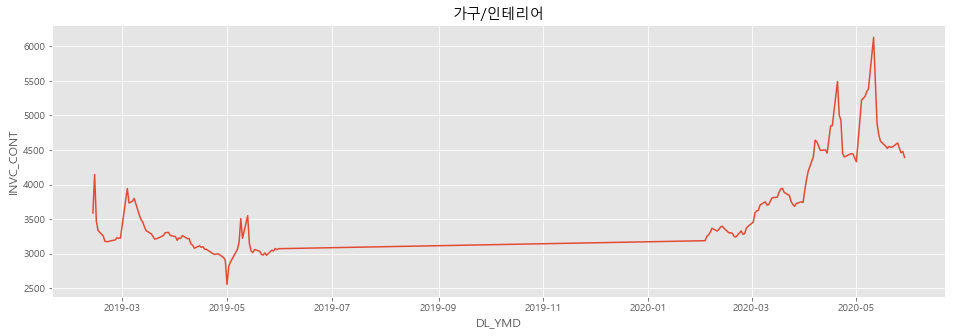

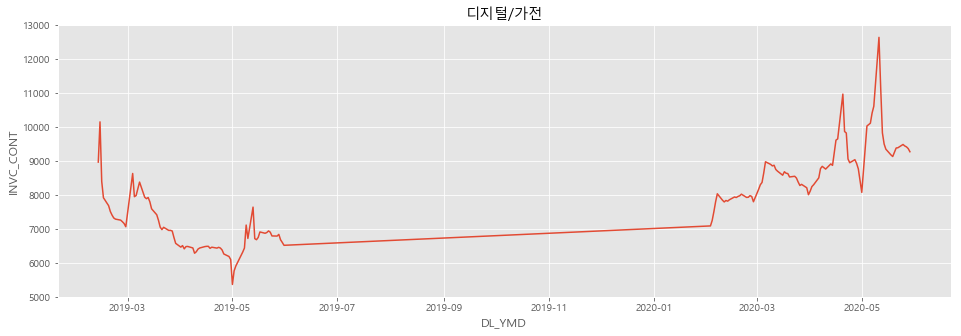

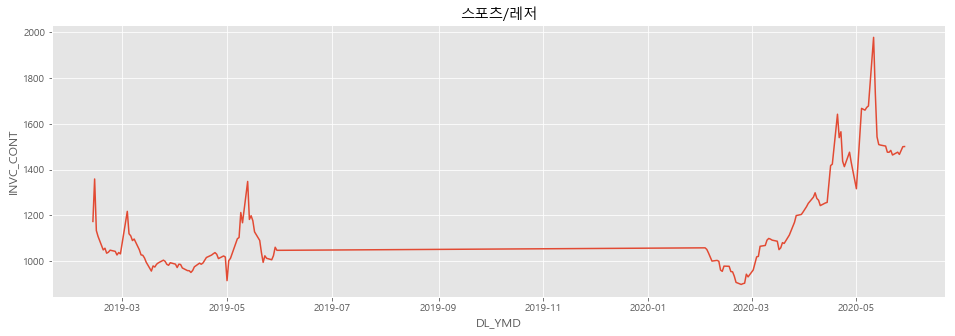

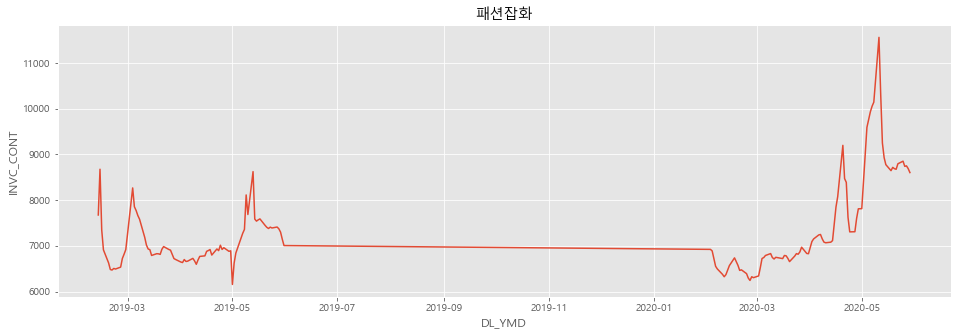

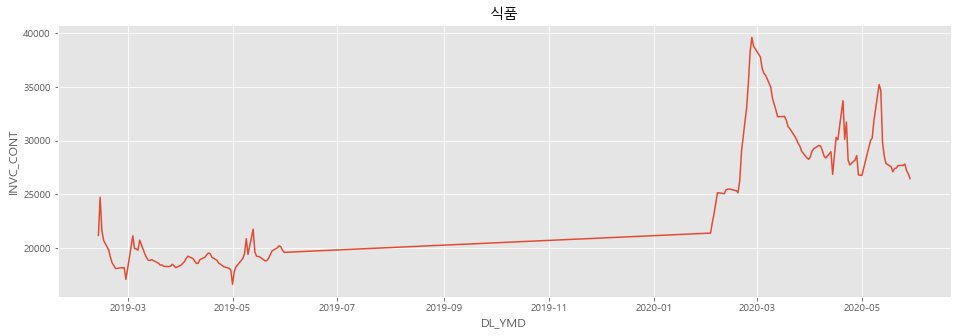

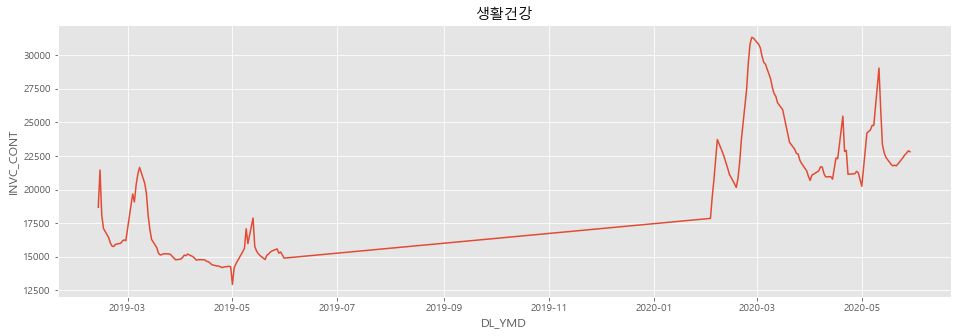

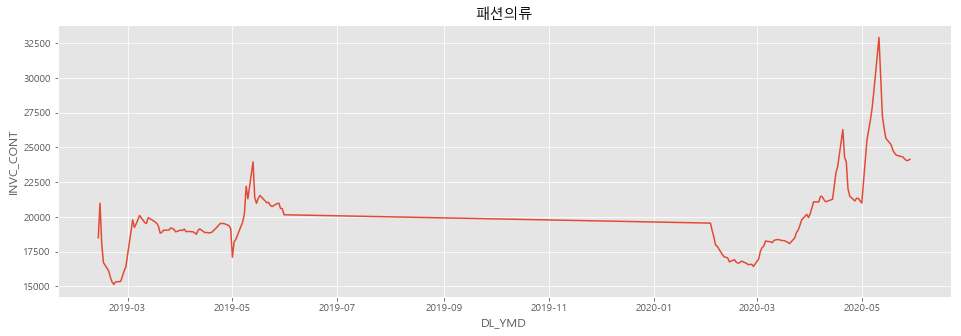

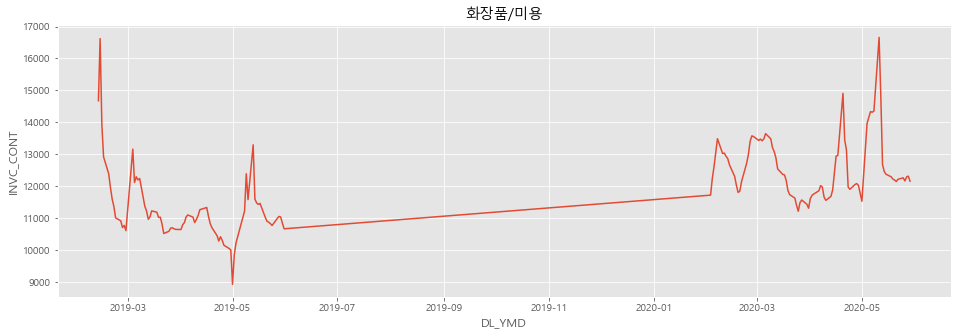

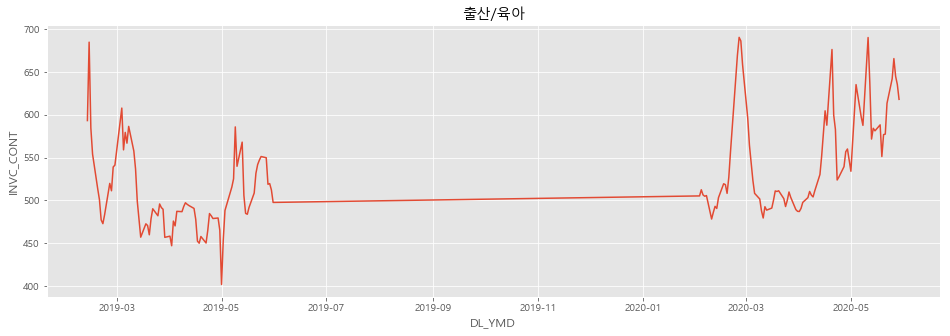

In [24]:
for cat in cj_deliv.DL_GD_LCLS_NM.unique():
    
    plt.figure(figsize=(16,5))
    sns.lineplot(
        x=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna().index,
        y=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna()
    )
    plt.title(cat)
    plt.show()

In [9]:
tmp_df = cj_deliv.loc[(cj_deliv.weekday == '평일')].groupby(['DL_GD_LCLS_NM','DL_YMD','year','weekofyear'])['INVC_CONT'].sum().reset_index()

In [65]:
tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
        reset_index().\
        groupby(['DL_GD_LCLS_NM','weekofyear']).\
        get_group(('패션의류',6))

,DL_GD_LCLS_NM,year,weekofyear,INVC_CONT
246,패션의류,2019,6,24054.0
263,패션의류,2020,6,17878.6


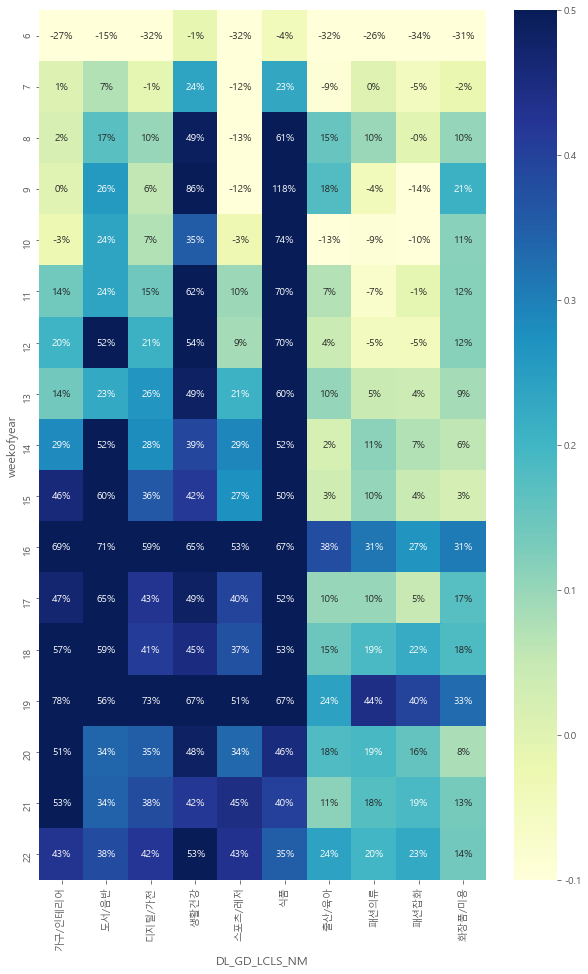

In [74]:
plt.figure(figsize=(10,16))
sns.heatmap(
    tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
        reset_index().\
        groupby(['DL_GD_LCLS_NM','weekofyear']).\
        apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1] if x.shape[0]==2 else 1).\
        reset_index(name='rate').\
        pivot('weekofyear','DL_GD_LCLS_NM','rate').\
        iloc[1:,:],
    cmap='YlGnBu', annot=True,vmin=-.1, vmax=.5, fmt='.0%'
)

* 송장건수
    * [가구/인테리어, 도서/음반, 디지털/가전, 생활건강, 스포츠/레저, 식품] 의 경우 전년 동주 대비 증가율이 높은편
    * [출산/육아, 패션의류, 패션잡화, 화장품/미용] 의 경우 전년동주 대비 증가율이 높지 않음

In [15]:
from sklearn.cluster import KMeans

In [16]:
km_clst = KMeans(n_clusters=3)

In [33]:
tmp_df

,DL_GD_LCLS_NM,DL_YMD,year,weekofyear,INVC_CONT
0,가구/인테리어,2019-02-01,2019,5,262
1,가구/인테리어,2019-02-04,2019,6,9
2,가구/인테리어,2019-02-05,2019,6,3
3,가구/인테리어,2019-02-06,2019,6,893
4,가구/인테리어,2019-02-07,2019,6,6001
...,...,...,...,...,...
1700,화장품/미용,2020-05-25,2020,22,18942
1701,화장품/미용,2020-05-26,2020,22,11370
1702,화장품/미용,2020-05-27,2020,22,10957
1703,화장품/미용,2020-05-28,2020,22,10403


In [11]:
tmp_pivot=tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
        reset_index().\
        groupby(['DL_GD_LCLS_NM','weekofyear']).\
        apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1] if x.shape[0]==2 else 1).\
        reset_index(name='rate').\
        pivot('DL_GD_LCLS_NM','weekofyear','rate').iloc[:,1:]

In [17]:
tmp_pivot['cluster']=km_clst.fit_predict(tmp_pivot)

In [18]:
tmp_pivot

weekofyear,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,cluster
DL_GD_LCLS_NM,,,,,,,,,,,,,,,,,,
가구/인테리어,0.665843,0.009534,0.018656,0.246000,-0.025257,0.143209,0.204599,0.141185,0.286661,0.459725,0.358817,0.468037,0.263403,0.724066,0.512288,0.526602,0.429473,0
도서/음반,0.309091,0.072352,0.170059,0.503640,0.237284,0.237292,0.523073,0.226293,0.523868,0.604397,0.405145,0.647775,0.301972,0.446423,0.339402,0.344384,0.383957,0
디지털/가전,0.561420,-0.007622,0.100699,0.311051,0.071292,0.145786,0.210065,0.263681,0.279789,0.360288,0.282349,0.428334,0.129437,0.695002,0.352252,0.381647,0.422108,0
생활건강,1.136446,0.235574,0.491397,1.301892,0.354349,0.624802,0.544629,0.485716,0.391443,0.416640,0.335258,0.485768,0.168842,0.594539,0.484311,0.419006,0.531676,1
스포츠/레저,-0.063798,-0.116766,-0.134109,0.103244,-0.028806,0.096807,0.085616,0.207126,0.290276,0.274088,0.230421,0.396797,0.100513,0.486240,0.335697,0.445015,0.432334,0
식품,1.131642,0.230331,0.605378,1.694789,0.740418,0.704192,0.701942,0.596322,0.520034,0.500561,0.349589,0.519677,0.232863,0.589087,0.455350,0.402880,0.350140,1
출산/육아,0.254591,-0.091697,0.153146,0.472719,-0.133356,0.069147,0.042840,0.102452,0.021346,0.034818,0.109218,0.101086,-0.078656,0.211626,0.181781,0.112845,0.241961,2
패션의류,0.607383,0.003351,0.097790,0.192549,-0.091903,-0.072200,-0.050658,0.045149,0.112369,0.101858,0.061151,0.100773,-0.046218,0.383345,0.190828,0.176534,0.198061,2
패션잡화,0.205084,-0.049806,-0.002680,0.070482,-0.104574,-0.006952,-0.047057,0.040238,0.072800,0.044090,0.018184,0.049753,-0.007016,0.356130,0.156265,0.189975,0.227767,2


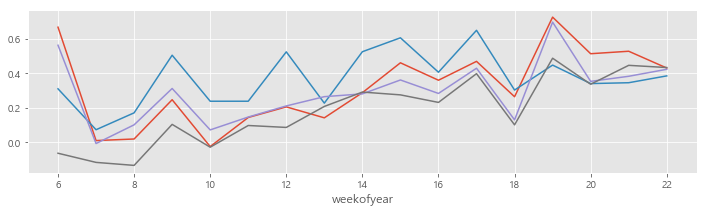

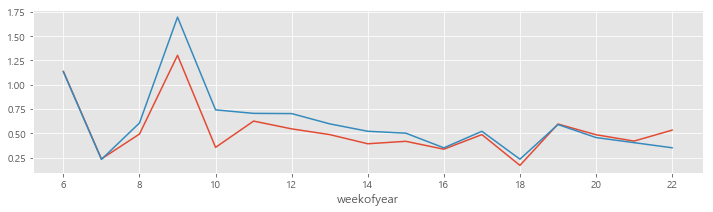

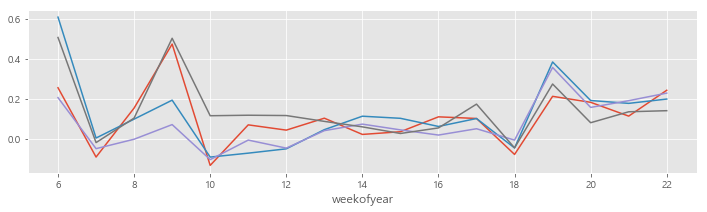

In [19]:
for i in range(3):
    data = tmp_pivot.loc[tmp_pivot.cluster==i]
    fig, ax = plt.subplots(figsize=(12,3))
    for j in range(data.shape[0]):
        data.T.iloc[:-1,j].plot(ax=ax)
    plt.show()

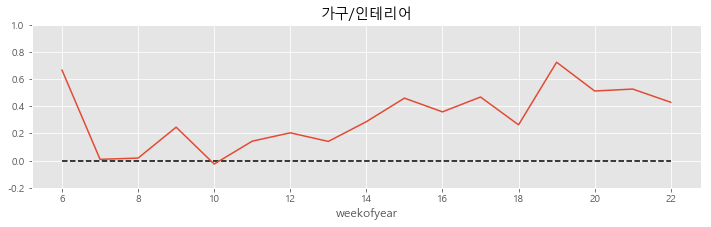

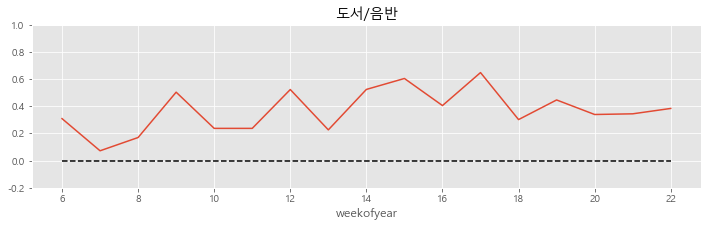

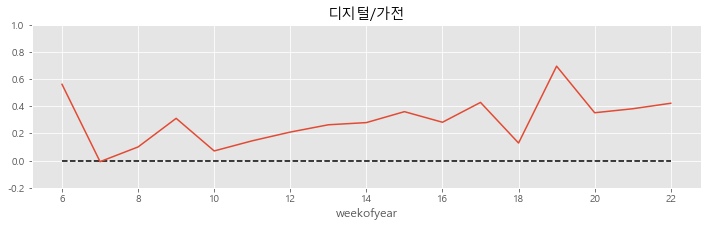

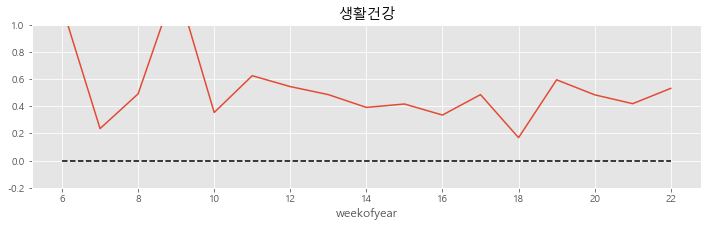

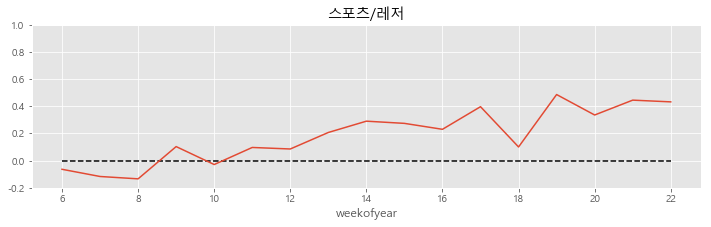

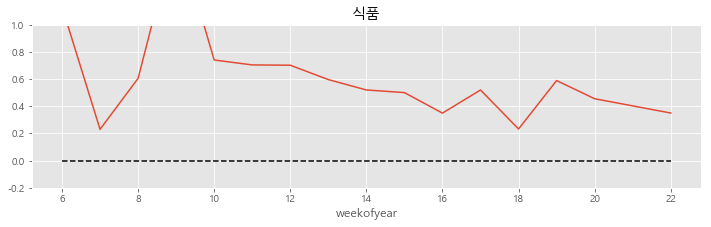

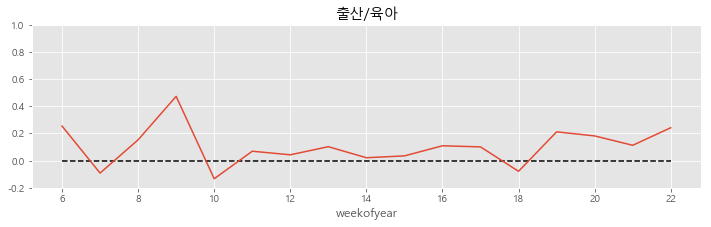

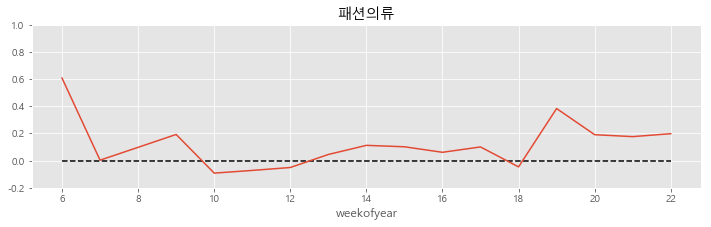

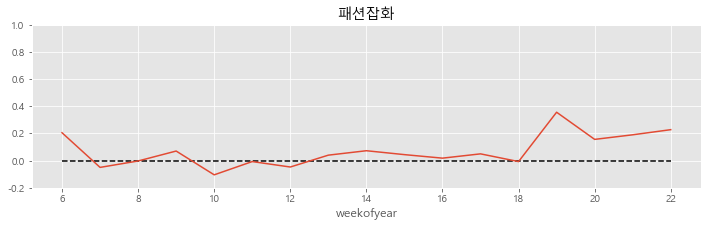

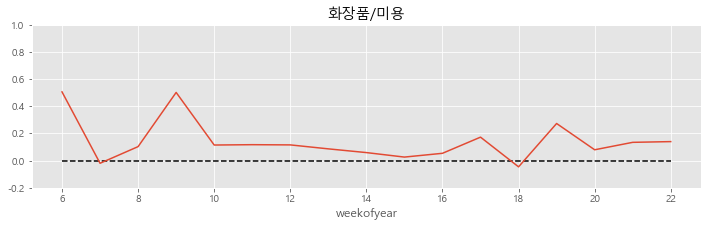

In [10]:
for col in tmp_df.DL_GD_LCLS_NM.unique():
    tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
            reset_index().\
            groupby(['DL_GD_LCLS_NM','weekofyear']).\
            apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1] if x.shape[0]==2 else 1).\
            reset_index(name='rate').\
            pivot('weekofyear','DL_GD_LCLS_NM','rate').\
            iloc[1:,:].loc[:,col].\
            plot(figsize=(12,3))
    plt.hlines(xmin=6, xmax=22, y=0, linestyles='--')
    plt.ylim(-0.2, 1)
    plt.title(col)
    plt.show()

### INDEX

In [25]:
register.groupby(['year','weekofyear'])['STD_DD'].apply(lambda x: list(x.unique()))

year  weekofyear
2019  5             [2019-02-01T00:00:00.000000000, 2019-02-02T00:...
      6             [2019-02-04T00:00:00.000000000, 2019-02-05T00:...
      7             [2019-02-11T00:00:00.000000000, 2019-02-12T00:...
      8             [2019-02-18T00:00:00.000000000, 2019-02-19T00:...
      9             [2019-02-25T00:00:00.000000000, 2019-02-26T00:...
      10            [2019-03-04T00:00:00.000000000, 2019-03-05T00:...
      11            [2019-03-11T00:00:00.000000000, 2019-03-12T00:...
      12            [2019-03-18T00:00:00.000000000, 2019-03-19T00:...
      13            [2019-03-25T00:00:00.000000000, 2019-03-26T00:...
      14            [2019-04-01T00:00:00.000000000, 2019-04-02T00:...
      15            [2019-04-08T00:00:00.000000000, 2019-04-09T00:...
      16            [2019-04-15T00:00:00.000000000, 2019-04-16T00:...
      17            [2019-04-22T00:00:00.000000000, 2019-04-23T00:...
      18            [2019-04-29T00:00:00.000000000, 2019-04-30T00:...
   

In [ ]:
# INDEX 기간 18주까지
# 시작주 8주차 (2월 17일-2월23일)
# 마지막주차 17주차 : 
# 18주차->19년 어린이날로 인해 평일 평균 송장건수가 높아짐.
# 19주차->20년 어린이날로 인해 평일 평균 송장건수 높아짐.
# 20주차~ -> 재난지원금지원으로 인해 정보들이 너무 희석됨

In [21]:
tmp_pivot.drop('cluster', axis=1, inplace=True)

In [32]:
tmp_pivot.iloc[:,2:-5]

weekofyear,8,9,10,11,12,13,14,15,16,17
DL_GD_LCLS_NM,,,,,,,,,,
가구/인테리어,0.018656,0.246000,-0.025257,0.143209,0.204599,0.141185,0.286661,0.459725,0.358817,0.468037
도서/음반,0.170059,0.503640,0.237284,0.237292,0.523073,0.226293,0.523868,0.604397,0.405145,0.647775
디지털/가전,0.100699,0.311051,0.071292,0.145786,0.210065,0.263681,0.279789,0.360288,0.282349,0.428334
생활건강,0.491397,1.301892,0.354349,0.624802,0.544629,0.485716,0.391443,0.416640,0.335258,0.485768
스포츠/레저,-0.134109,0.103244,-0.028806,0.096807,0.085616,0.207126,0.290276,0.274088,0.230421,0.396797
식품,0.605378,1.694789,0.740418,0.704192,0.701942,0.596322,0.520034,0.500561,0.349589,0.519677
출산/육아,0.153146,0.472719,-0.133356,0.069147,0.042840,0.102452,0.021346,0.034818,0.109218,0.101086
패션의류,0.097790,0.192549,-0.091903,-0.072200,-0.050658,0.045149,0.112369,0.101858,0.061151,0.100773
패션잡화,-0.002680,0.070482,-0.104574,-0.006952,-0.047057,0.040238,0.072800,0.044090,0.018184,0.049753


In [ ]:
def impact_index_online(deliv_df):
    
    tmp_df = deliv_df.loc[(deliv_df.weekday == '평일')].\
                    groupby(['DL_GD_LCLS_NM','DL_YMD','year','weekofyear'])['INVC_CONT'].sum().\
                    reset_index()
            
    # 8주 ~ 17주
    tmp_pivot=tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
        reset_index().\
        groupby(['DL_GD_LCLS_NM','weekofyear']).\
        apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1] if x.shape[0]==2 else 1).\
        reset_index(name='rate').\
        pivot('DL_GD_LCLS_NM','weekofyear','rate').iloc[:,3:-5]
        
        
    

In [26]:
tmp_pivot

weekofyear,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
DL_GD_LCLS_NM,,,,,,,,,,,,,,,,,
가구/인테리어,0.665843,0.009534,0.018656,0.246000,-0.025257,0.143209,0.204599,0.141185,0.286661,0.459725,0.358817,0.468037,0.263403,0.724066,0.512288,0.526602,0.429473
도서/음반,0.309091,0.072352,0.170059,0.503640,0.237284,0.237292,0.523073,0.226293,0.523868,0.604397,0.405145,0.647775,0.301972,0.446423,0.339402,0.344384,0.383957
디지털/가전,0.561420,-0.007622,0.100699,0.311051,0.071292,0.145786,0.210065,0.263681,0.279789,0.360288,0.282349,0.428334,0.129437,0.695002,0.352252,0.381647,0.422108
생활건강,1.136446,0.235574,0.491397,1.301892,0.354349,0.624802,0.544629,0.485716,0.391443,0.416640,0.335258,0.485768,0.168842,0.594539,0.484311,0.419006,0.531676
스포츠/레저,-0.063798,-0.116766,-0.134109,0.103244,-0.028806,0.096807,0.085616,0.207126,0.290276,0.274088,0.230421,0.396797,0.100513,0.486240,0.335697,0.445015,0.432334
식품,1.131642,0.230331,0.605378,1.694789,0.740418,0.704192,0.701942,0.596322,0.520034,0.500561,0.349589,0.519677,0.232863,0.589087,0.455350,0.402880,0.350140
출산/육아,0.254591,-0.091697,0.153146,0.472719,-0.133356,0.069147,0.042840,0.102452,0.021346,0.034818,0.109218,0.101086,-0.078656,0.211626,0.181781,0.112845,0.241961
패션의류,0.607383,0.003351,0.097790,0.192549,-0.091903,-0.072200,-0.050658,0.045149,0.112369,0.101858,0.061151,0.100773,-0.046218,0.383345,0.190828,0.176534,0.198061
패션잡화,0.205084,-0.049806,-0.002680,0.070482,-0.104574,-0.006952,-0.047057,0.040238,0.072800,0.044090,0.018184,0.049753,-0.007016,0.356130,0.156265,0.189975,0.227767


In [78]:
tmp_df.query('weekofyear==16').DL_YMD.unique()

array(['2019-04-15T00:00:00.000000000', '2019-04-16T00:00:00.000000000',
       '2019-04-17T00:00:00.000000000', '2019-04-18T00:00:00.000000000',
       '2019-04-19T00:00:00.000000000', '2020-04-13T00:00:00.000000000',
       '2020-04-14T00:00:00.000000000', '2020-04-16T00:00:00.000000000',
       '2020-04-17T00:00:00.000000000'], dtype='datetime64[ns]')

In [45]:
cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.year==2020) & (cj_deliv.month < 5)].groupby(['DL_YMD','DL_GD_LCLS_NM'])['INVC_CONT'].sum().reset_index()

,DL_YMD,DL_GD_LCLS_NM,INVC_CONT
0,2020-02-03,가구/인테리어,5168
1,2020-02-03,도서/음반,8468
2,2020-02-03,디지털/가전,12720
3,2020-02-03,생활건강,36825
4,2020-02-03,스포츠/레저,1545
...,...,...,...
635,2020-04-30,식품,648
636,2020-04-30,출산/육아,8
637,2020-04-30,패션의류,218
638,2020-04-30,패션잡화,525


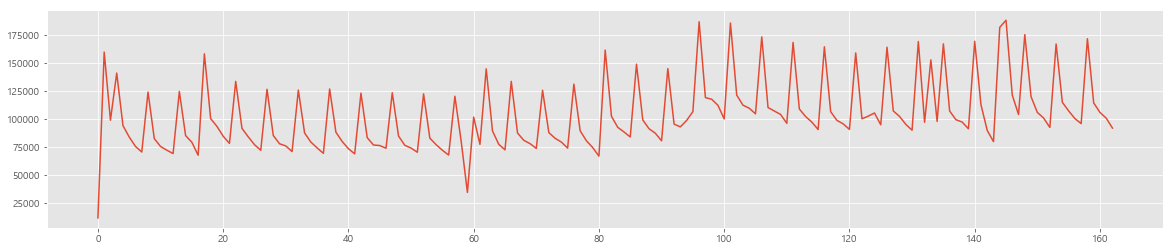

In [29]:
cj_deliv.loc[(cj_deliv.weekday == '평일')].groupby(['year','month','weekofyear','dayofweek'])['INVC_CONT'].sum().reset_index().INVC_CONT.plot(figsize=(20,4))

In [32]:
cj_deliv.loc[(cj_deliv.weekday == '평일')].groupby(['year','month','weekofyear','dayofweek'])['INVC_CONT'].sum().reset_index().groupby(['dayofweek']).INVC_CONT.mean().reset_index()

,dayofweek,INVC_CONT
0,0,150193.750000
1,1,99866.062500
2,2,92848.406250
3,3,92855.878788
4,4,81755.205882


c:\python37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


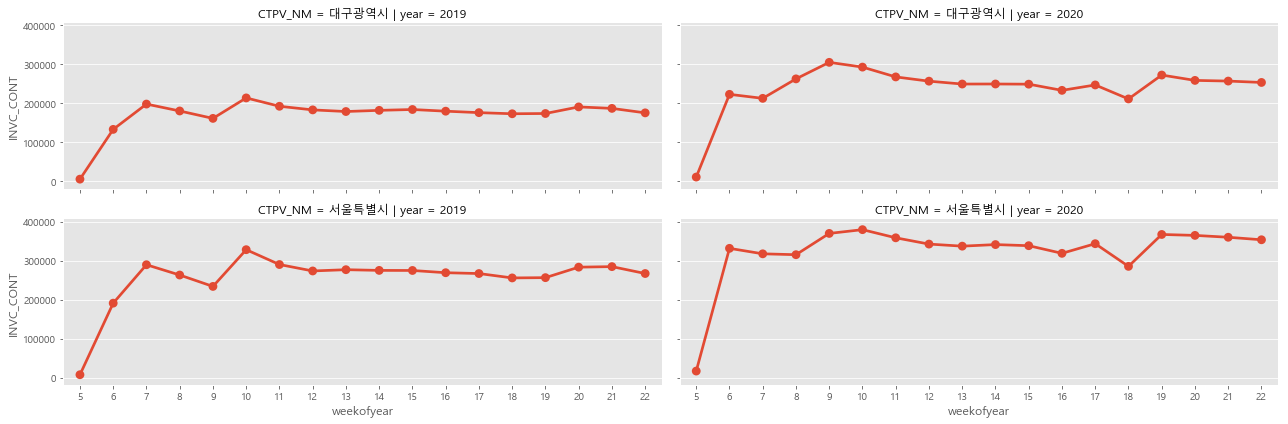

In [44]:
# 월별 송장건수
g = sns.FacetGrid(data=cj_deliv.groupby(['CTPV_NM','year','weekofyear'])['INVC_CONT'].sum().reset_index(), col='year', row='CTPV_NM',aspect=3)
g.map(sns.pointplot, 'weekofyear', 'INVC_CONT')

c:\python37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


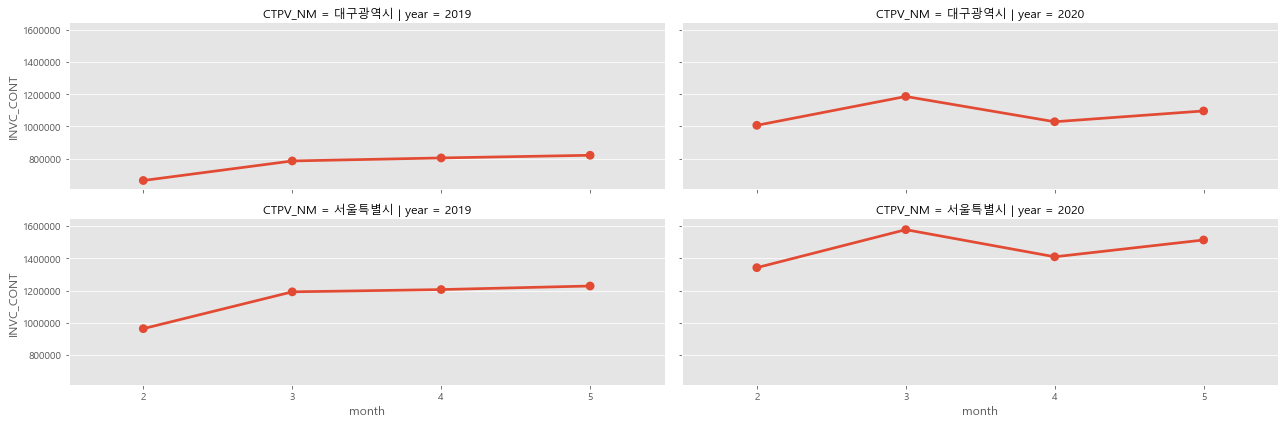

In [45]:
# 월별 송장건수
g = sns.FacetGrid(data=cj_deliv.groupby(['CTPV_NM','year','month'])['INVC_CONT'].sum().reset_index(), col='year', row='CTPV_NM',aspect=3)
g.map(sns.pointplot, 'month', 'INVC_CONT')

In [36]:
cj_deliv.loc[(cj_deliv.weekday == '평일')]

,DL_YMD,DL_GD_LCLS_NM,DL_GD_LCLS_CD,CTPV_NM,CTPV_CD,CTGG_NM,CTGG_CD,HDNG_NM,HDNG_CD,INVC_CONT,year,month,weekofyear,dayofweek,weekday
0,2019-02-01,도서/음반,12,서울특별시,11,중구,14,동화동,665,16,2019,2,5,4,평일
1,2019-02-01,가구/인테리어,10,서울특별시,11,중구,14,신당동,615,4,2019,2,5,4,평일
2,2019-02-01,가구/인테리어,10,대구광역시,27,중구,11,성내1동,565,1,2019,2,5,4,평일
3,2019-02-01,도서/음반,12,대구광역시,27,중구,11,남산2동,650,6,2019,2,5,4,평일
4,2019-02-01,디지털/가전,13,대구광역시,27,수성구,26,고산3동,690,21,2019,2,5,4,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155388,2020-05-29,패션잡화,20,대구광역시,27,중구,11,대봉2동,690,5,2020,5,22,4,평일
155389,2020-05-29,화장품/미용,21,대구광역시,27,수성구,26,고산1동,670,210,2020,5,22,4,평일
155390,2020-05-29,패션잡화,20,서울특별시,11,중구,14,명동,550,137,2020,5,22,4,평일
155391,2020-05-29,패션잡화,20,대구광역시,27,중구,11,남산3동,660,29,2020,5,22,4,평일


([<matplotlib.axis.XTick at 0x2c528e5c908>,
 <a list of 5 Text xticklabel objects>)

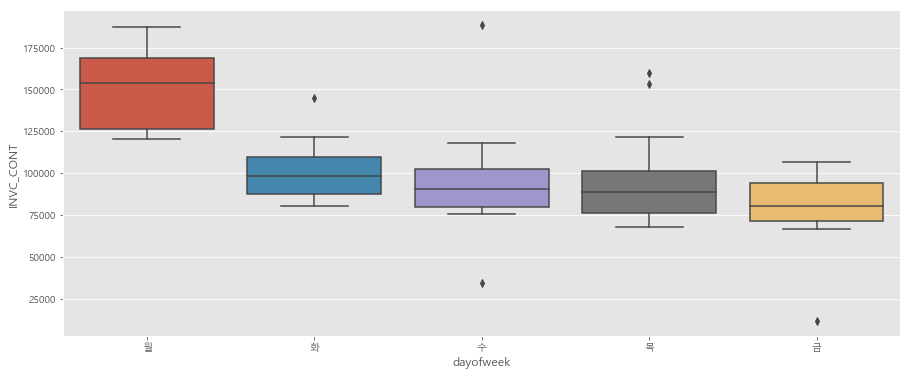

In [35]:
plt.figure(figsize=(15,6))
sns.boxplot(
    data = cj_deliv.loc[(cj_deliv.weekday == '평일')].groupby(['year','month','weekofyear','dayofweek'])['INVC_CONT'].sum().reset_index(),
    x = 'dayofweek',
    y = 'INVC_CONT'
)

plt.xticks(ticks=[0,1,2,3,4], labels=['월','화','수','목','금'])

### 카드소비와 물류량 간의 상관관계

In [119]:
register['SI_NM'] = register.HDONG_NM.map(dict(cj_deliv.drop_duplicates('HDNG_NM', keep='last').set_index('HDNG_NM')['CTPV_NM']))

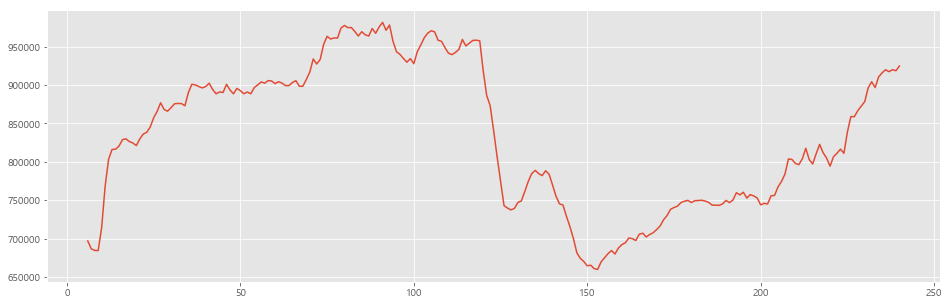

In [133]:
register.loc[register.SI_NM=='서울특별시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().plot(figsize=(16,5))

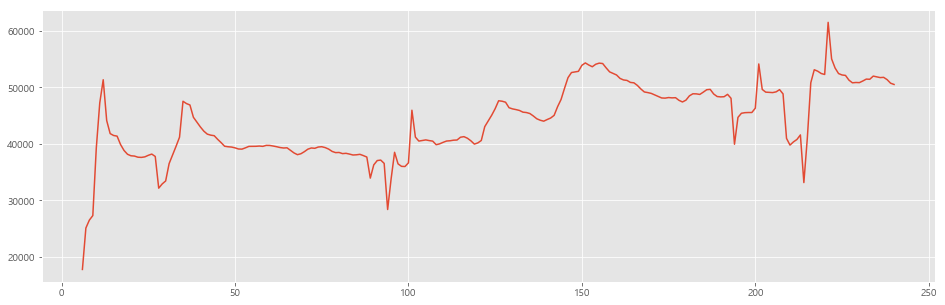

In [140]:
cj_deliv.loc[cj_deliv.CTPV_NM=='서울특별시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().plot(figsize=(16,5))

Text(0.5, 1.0, '서울특별시 - 송장건수 및 소비횟수')

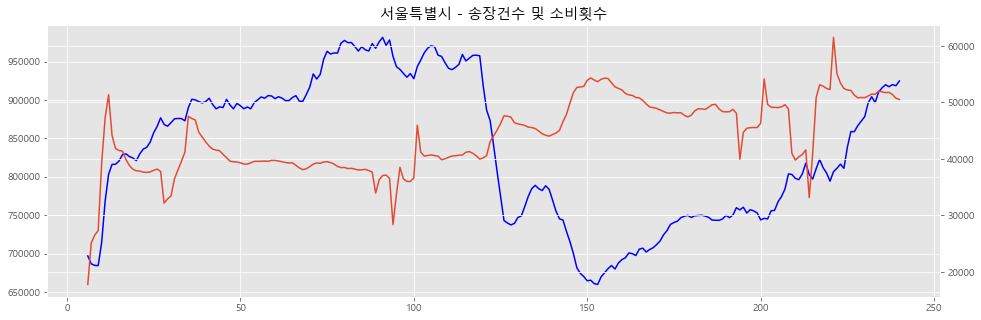

In [163]:
fig, ax = plt.subplots(figsize=(16,5))
register.loc[register.SI_NM=='서울특별시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().plot(ax=ax, color='b')
g = ax.twinx()
g = cj_deliv.loc[cj_deliv.CTPV_NM=='서울특별시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().plot()

ax.set_title('서울특별시 - 송장건수 및 소비횟수')

Text(0.5, 1.0, '대구광역시 - 송장건수 및 소비횟수')

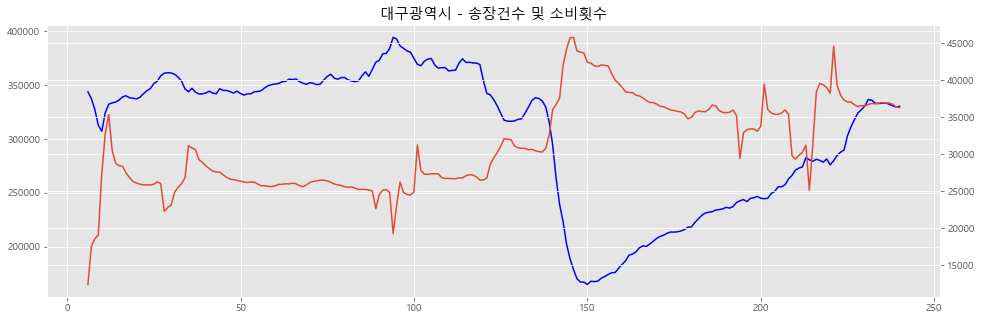

In [164]:
fig, ax = plt.subplots(figsize=(16,5))
register.loc[register.SI_NM=='대구광역시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().plot(ax=ax, color='b')
g = ax.twinx()
g = cj_deliv.loc[cj_deliv.CTPV_NM=='대구광역시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().plot()
ax.set_title('대구광역시 - 송장건수 및 소비횟수')

In [158]:
tmp_card=register.groupby('STD_DD')['USE_CNT'].sum().reset_index()
tmp_deliv=cj_deliv.loc[cj_deliv.weekday=='평일'].groupby('DL_YMD')['INVC_CONT'].sum().reset_index().rename(columns={'DL_YMD':'STD_DD'})

In [166]:
tmp_card_2019=register.query('year==2019').groupby('STD_DD')['USE_CNT'].sum().reset_index()
tmp_deliv_2019=cj_deliv.query('year==2019').loc[cj_deliv.weekday=='평일'].groupby('DL_YMD')['INVC_CONT'].sum().reset_index().rename(columns={'DL_YMD':'STD_DD'})

In [167]:
tmp_card_2020=register.query('year==2020').groupby('STD_DD')['USE_CNT'].sum().reset_index()
tmp_deliv_2020=cj_deliv.query('year==2020').loc[cj_deliv.weekday=='평일'].groupby('DL_YMD')['INVC_CONT'].sum().reset_index().rename(columns={'DL_YMD':'STD_DD'})

In [173]:
tmp_deliv_2019.merge(tmp_card_2019).iloc[:,1:].corr()

,INVC_CONT,USE_CNT
INVC_CONT,1.000000,-0.430615
USE_CNT,-0.430615,1.000000


In [169]:
tmp_deliv_2020.merge(tmp_card_2020).iloc[:,1:].corr()

,INVC_CONT,USE_CNT
INVC_CONT,1.000000,-0.152252
USE_CNT,-0.152252,1.000000


In [162]:
tmp_deliv.merge(tmp_card).iloc[:,1:].corr()

,INVC_CONT,USE_CNT
INVC_CONT,1.000000,-0.474265
USE_CNT,-0.474265,1.000000


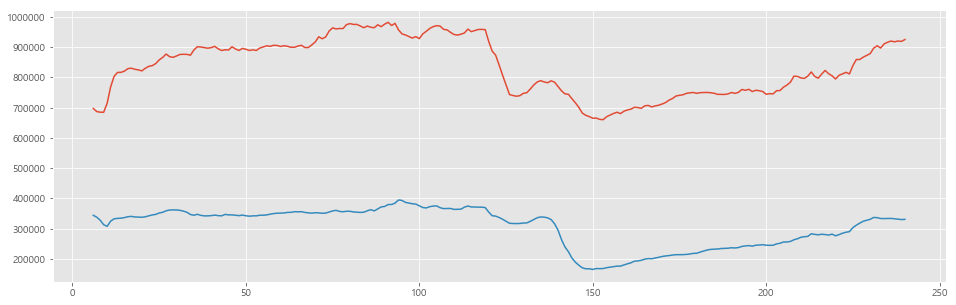

In [135]:
register.loc[register.SI_NM=='서울특별시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().plot(figsize=(16,5))
register.loc[register.SI_NM=='대구광역시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().plot(figsize=(16,5))

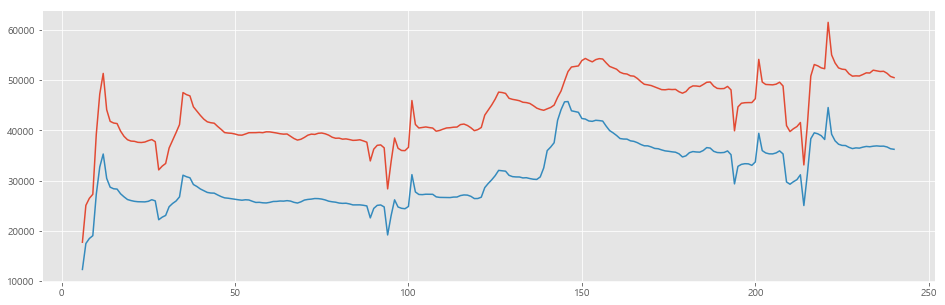

In [142]:
cj_deliv.loc[cj_deliv.CTPV_NM=='서울특별시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().plot(figsize=(16,5))
cj_deliv.loc[cj_deliv.CTPV_NM=='대구광역시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().plot(figsize=(16,5))